In [1]:
# 1. Install (optional in Colab) and import libraries
!pip install -q scikit-learn pandas matplotlib numpy

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name='target')
print("Using Iris dataset — shape:", X.shape)

Using Iris dataset — shape: (150, 4)


In [3]:
# 3. Quick EDA
print("Class counts:\n", y.value_counts())
display(X.head())
print("\nFeature names:", list(X.columns))


Class counts:
 target
0    50
1    50
2    50
Name: count, dtype: int64


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2



Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [4]:
# 4. Select features (all features for model; for plotting we'll pick two)
X_all = X.copy()   # use all features for final model

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

# For decision-boundary visualization pick two features (e.g., sepal length and sepal width)
feat_idx = [0, 1]  # change indices if you prefer other features (0..3 for iris)
X_vis = X_all.iloc[:, feat_idx].values
X_vis_scaled = StandardScaler().fit_transform(X_vis)  # separate scaler for plotting


In [5]:
# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (112, 4) Test shape: (38, 4)


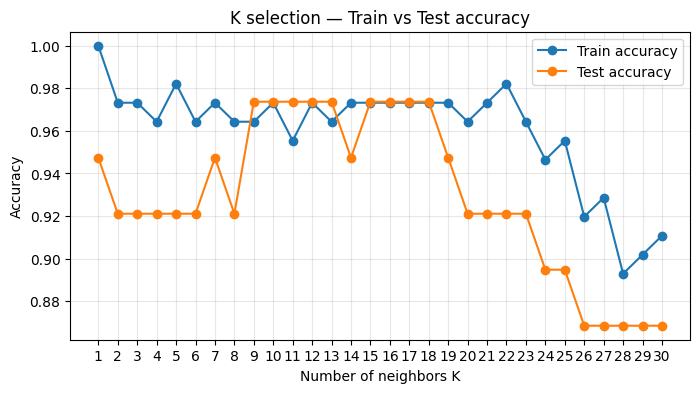

Best K by test accuracy: K = 9, test accuracy = 0.9737


In [6]:
# 6.1 Try multiple K values and record accuracy
k_values = list(range(1, 31))
train_acc = []
test_acc = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_acc.append(knn.score(X_train, y_train))
    test_acc.append(knn.score(X_test, y_test))

# 6.2 Plot accuracy vs K
plt.figure(figsize=(8,4))
plt.plot(k_values, train_acc, label='Train accuracy', marker='o')
plt.plot(k_values, test_acc, label='Test accuracy', marker='o')
plt.xlabel('Number of neighbors K')
plt.ylabel('Accuracy')
plt.title('K selection — Train vs Test accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 6.3 Print best K by test accuracy (if multiple, show smallest K)
best_k = k_values[np.argmax(test_acc)]
print(f"Best K by test accuracy: K = {best_k}, test accuracy = {max(test_acc):.4f}")


Test accuracy: 0.9736842105263158

Classification report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.93      1.00      0.96        13
   virginica       1.00      0.92      0.96        13

    accuracy                           0.97        38
   macro avg       0.98      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38

Confusion matrix:
 [[12  0  0]
 [ 0 13  0]
 [ 0  1 12]]


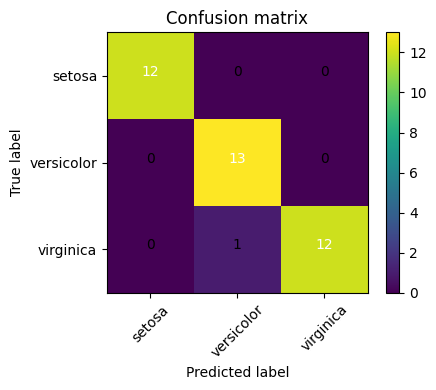

In [7]:
# 7. Train final model with best_k
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train, y_train)
y_pred = final_knn.predict(X_test)

# 7.1 Accuracy & classification report
acc = accuracy_score(y_test, y_pred)
print("Test accuracy:", acc)
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=iris.target_names))

# 7.2 Confusion matrix (and a simple plot)
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>cm.max()/2 else "black")
plt.xticks(np.arange(len(iris.target_names)), iris.target_names, rotation=45)
plt.yticks(np.arange(len(iris.target_names)), iris.target_names)
plt.tight_layout()
plt.show()


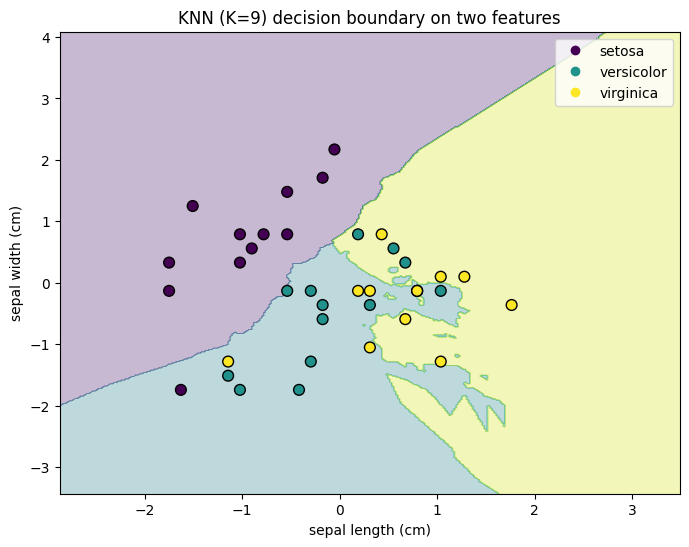

In [9]:
# 8. Prepare 2D data for visualization
X2 = X_vis_scaled  # two features scaled
y2 = y.values      # labels

# split for visualization (not the same as earlier split)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=42, stratify=y2)

# train a 2D KNN for plotting
knn2 = KNeighborsClassifier(n_neighbors=best_k)
knn2.fit(X2_train, y2_train)

# create meshgrid
h = 0.02  # step in the mesh
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3)
scatter = plt.scatter(X2_test[:,0], X2_test[:,1], c=y2_test, edgecolor='k', s=60)
plt.xlabel(X.columns[feat_idx[0]])
plt.ylabel(X.columns[feat_idx[1]])
plt.title(f"KNN (K={best_k}) decision boundary on two features")

# FIXED LEGEND (convert numpy array to list)
plt.legend(handles=scatter.legend_elements()[0], labels=list(iris.target_names))
plt.show()

